In [1]:
import torch
import pickle as pk
import numpy as np

In [2]:
snli_train_id = pk.load(open("./hw2_data/snli_train_id.pk", "rb"))
snli_val_id = pk.load(open("./hw2_data/snli_val_id.pk", "rb"))
loaded_embeddings_ft = pk.load(open("./hw2_data/loaded_embeddings_ft.pk", "rb"))

In [57]:
import tqdm
import torch
import torch.nn.functional as F
from models import RNN
from SNLI_DataLoader import SNLIDataset, snli_collate_func

class rnn_trainer():
    
    def __init__(self, train_data, val_data, pre_trained_emb, args):
        
        self.device = torch.device(args['device'])
        
        #data
        self.train_data = train_data
        self.val_data = val_data
        self.batch_size = args['batch_size']
        
        #init model
        model_args = {'hidden_size': args['hidden_size'], 
                     'num_layers': args['num_layers'],
                     'num_classes': args['num_classes'],
                     'dropout': args['dropout'],
                     'device': self.device
                     }
        self.model = RNN(model_args, pre_trained_emb)
        
        #training-level parameter
        self.lr = args['learning_rate']
        if args['optim'] == 'adam':
            self.optim = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        self.criterion = torch.nn.CrossEntropyLoss()
        self.num_epochs = args['num_epochs']
        
    def _load_data(self):
        train_dataset = SNLIDataset(self.train_data)
        self.train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                                   batch_size=self.batch_size,
                                                   collate_fn=snli_collate_func,
                                                   shuffle=True)
        val_dataset = SNLIDataset(self.val_data)
        self.val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                                   batch_size=self.batch_size,
                                                   collate_fn=snli_collate_func,
                                                   shuffle=True)

    def train_stage(self):
        for data in self.train_loader:
            prem, prem_len, hyp, hyp_len, labels = [data[i].to(self.device) for i in range(len(data))]
            self.model.train()
            self.optim.zero_grad()
            # Forward pass
            outputs = self.model(prem, prem_len, hyp, hyp_len)
            loss = self.criterion(outputs, labels)

            # Backward and optimize
            loss.backward()
            self.optim.step()
        
    def eval_stage(self):
        correct = 0
        total = 0
        self.model.eval()
        for data in self.val_loader:
            prem, prem_len, hyp, hyp_len, labels = [data[i].to(self.device) for i in range(len(data))]
            outputs = F.softmax(self.model(prem, prem_len, hyp, hyp_len), dim=1)
            predicted = outputs.max(1, keepdim=True)[1]

            total += labels.size(0)
            correct += predicted.eq(labels.view_as(predicted)).sum().item()
        return (100 * correct / total)

    def go(self,):
        self._load_data()
        val_acc_list = []
        for epoch in tqdm.trange(self.num_epochs):
            self.train_stage()
            val_acc = self.eval_stage()
            val_acc_list.append(val_acc)
        return val_acc_list

In [3]:
from rnn_trainer import rnn_trainer

In [4]:
hidden_size_list = [100,200,300]
dropout_list = [0,0.5]

In [14]:
args= {}
args['num_layers'] = 1
args['num_classes'] = 3
args['device'] = 'cuda'
args['batch_size'] = 64
args['optim'] = 'adam'
args['learning_rate'] = 3e-4
args['num_epochs'] = 50

for h in hidden_size_list[1:]:
    for d in dropout_list:
        args['hidden_size'] = h
        args['dropout'] = d
        trainer = rnn_trainer(snli_train_id, snli_val_id, loaded_embeddings_ft, args)
        val_list = trainer.go()
        pk.dump(val_list, open('./result/rnn_h=%s_d=%s'%(h,d), 'wb'))
        print('finish hidden_size = %s, dropout = %s, val_acc = %s'%(h,d,val_list[-1]))

  0%|          | 0/50 [00:00<?, ?it/s]

finish hidden_size = 200, dropout = 0, val_acc = 68.6


  0%|          | 0/50 [00:00<?, ?it/s]

finish hidden_size = 200, dropout = 0.5, val_acc = 67.3


  0%|          | 0/50 [00:00<?, ?it/s]

finish hidden_size = 300, dropout = 0, val_acc = 68.3


100%|██████████| 50/50 [23:12<00:00, 27.84s/it]

finish hidden_size = 300, dropout = 0.5, val_acc = 69.0


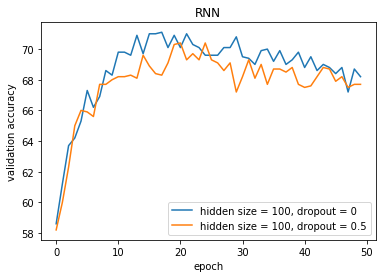

In [13]:
import matplotlib.pyplot as plt 
for h in hidden_size_list:
    for d in dropout_list:
        val_acc = pk.load(open('./result/rnn_h=%s_d=%s'%(h,d), 'rb'))
        plt.plot(range(len(val_acc)),val_acc, label = 'hidden size = %s, dropout = %s'%(h,d))
        plt.title('RNN')
        plt.ylabel('validation accuracy')
        plt.xlabel('epoch')
    plt.legend()
    break